<a href="https://colab.research.google.com/github/dajebbar/FreeCodeCamp-python-data-analysis/blob/main/why_need_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# The framework and why do we need it
---

Let's first look at the limitation of using a dataset without keeping any samples out.

To illustrate the different concepts, we will use the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing


housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In this dataset, the aim is to predict the median value of houses in an area in California. The features collected are based on general real-estate and geographical information.

This, we will use a predictive model specific to regression and not to classification.

In [2]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
data.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [5]:
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [6]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

To simplify future visualization, let's transform the prices from the 100 (k$) range to the thousand dollars (k\$) range.

In [7]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Training error vs testing error
To solve this regression task, we will use a decision tree regressor.

In [8]:
from sklearn.tree import DecisionTreeRegressor


regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=42)

After training the regressor, we would like to know its potential generalization performance once deployed in production. For this purpose, we use the mean absolute error, which gives us an error in the native unit, i.e. k$.

In [9]:
from sklearn.metrics import mean_absolute_error

target_preds = regressor.predict(data)
score = mean_absolute_error(target, target_preds)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We get perfect prediction with no error. It is too optimistic and almost always revealing a methodological problem when doing machine learning.

Indeed, we trained and predicted on the same dataset. Since our decision tree was fully grown, every sample in the dataset is stored in a leaf node. Therefore, our decision tree fully memorized the dataset given during `fit` and therefore made no error when predicting.

This error computed above is called the **empirical error** or **training error**.

Thus, the most basic evaluation involves:

-  splitting our dataset into two subsets: a training set and a testing set;
-  fitting the model on the training set;
-  estimating the training error on the training set;
-  estimating the testing error on the testing set.  

So let's split our dataset.

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target, 
                                                    random_state=42)

Then, let's train our model.

In [11]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [12]:
target_preds = regressor.predict(X_train)
score = mean_absolute_error(y_train, target_preds)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We observe the same phenomena as in the previous experiment: our model memorized the training set. However, we now compute the testing error.

In [13]:
target_preds = regressor.predict(X_test)
score = mean_absolute_error(y_test, target_preds)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 46.33 k$


This testing error is actually about what we would expect from our model if it was used in a production environment.

---
Stability of the cross-validation estimates
When doing a single train-test split we don't give any indication regarding the robustness of the evaluation of our predictive model: in particular, if the test set is small, this estimate of the testing error will be unstable and wouldn't reflect the "true error rate" we would have observed with the same model on an unlimited amount of test data.

For instance, we could have been lucky when we did our random split of our limited dataset and isolated some of the easiest cases to predict in the testing set just by chance: the estimation of the testing error would be overly optimistic, in this case.

**Cross-validation** allows estimating the robustness of a predictive model by repeating the splitting procedure. It will give several training and testing errors and thus some **estimate of the variability of the model generalization performance**.

There are different cross-validation strategies, for now we are going to focus on one called "shuffle-split". At each iteration of this strategy we:

- randomly shuffle the order of the samples of a copy of the full dataset;
- split the shuffled dataset into a train and a test set;
- train a new model on the train set;
- evaluate the testing error on the test set.  

We repeat this procedure `n_splits` times. Using `n_splits=40` means that we will train 40 models in total and all of them will be discarded: we just record their generalization performance on each variant of the test set.

To evaluate the generalization performance of our regressor, we can use `sklearn.model_selection.cross_validate` with a `sklearn.model_selection.ShuffleSplit` object:

In [18]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=.3, random_state=42)

cv_results = cross_validate(regressor,
                            data,
                            target,
                            scoring='neg_mean_absolute_error',
                            cv=cv)

The results cv_results are stored into a Python dictionary. We will convert it into a pandas dataframe to ease visualization and manipulation.

In [19]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.253402,0.007004,-47.329969
1,0.370430,0.028548,-45.871795
2,0.405257,0.004798,-46.721323
3,0.167540,0.004920,-46.637444
4,0.163460,0.004526,-46.978982


A score is a metric for which higher values mean better results. On the contrary, an error is a metric for which lower values mean better results. The parameter scoring in cross_validate always expect a function that is a score.

To make it easy, all error metrics in scikit-learn, like mean_absolute_error, can be transformed into a score to be used in cross_validate. To do so, you need to pass a string of the error metric with an additional neg_ string at the front to the parameter scoring; for instance scoring="neg_mean_absolute_error". In this case, the negative of the mean absolute error will be computed which would be equivalent to a score.

Let us revert the negation to get the actual error:

In [20]:
cv_results['test_error'] = -cv_results['test_score']
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.253402,0.007004,-47.329969,47.329969
1,0.370430,0.028548,-45.871795,45.871795
2,0.405257,0.004798,-46.721323,46.721323
3,0.167540,0.004920,-46.637444,46.637444
4,0.163460,0.004526,-46.978982,46.978982


We get timing information to fit and predict at each cross-validation iteration. Also, we get the test score, which corresponds to the testing error on each of the splits.

In [21]:
len(cv_results)

40

We get 40 entries in our resulting dataframe because we performed 40 splits. Therefore, we can show the testing error distribution and thus, have an estimate of its variability.

Text(0, 0.5, 'Frequency')

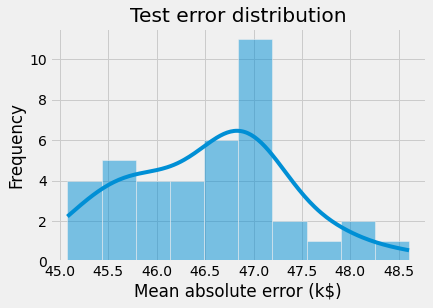

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

sns.histplot(data=cv_results, x='test_error', bins=10, kde=True, legend=False)
plt.title("Test error distribution")
plt.xlabel("Mean absolute error (k$)")
plt.ylabel("Frequency")

We observe that the testing error is clustered around 47 k\$ and ranges from 45 k\$ to 49 k\$.

In [30]:
print(f"The mean cross-validated testing error is: "
      f"{cv_results['test_error'].mean():.2f} k$")

The mean cross-validated testing error is: 46.53 k$


In [31]:
print(f"The standard deviation of the testing error is: "
      f"{cv_results['test_error'].std():.2f} k$")

The standard deviation of the testing error is: 0.83 k$


Note that the standard deviation is much smaller than the mean: we could summarize that our cross-validation estimate of the testing error is 46.53 +/- 0.83 k$.

If we were to train a single model on the full dataset (without cross-validation) and then later had access to an unlimited amount of test data, we would expect its true testing error to fall close to that region.

While this information is interesting in itself, it should be contrasted to the scale of the natural variability of the vector target in our dataset.

Let us plot the distribution of the target variable:

Text(0.5, 1.0, 'Target distribution')

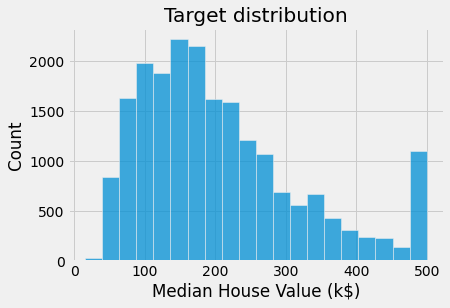

In [35]:
sns.histplot(x=target, bins=20, legend=False)
plt.xlabel("Median House Value (k$)")
plt.title("Target distribution")

In [36]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


The target variable ranges from close to 0 k$ up to 500k and, with a standard deviation around 115 k.

We notice that the mean estimate of the testing error obtained by cross-validation is a bit smaller than the natural scale of variation of the target variable. Furthermore, the standard deviation of the cross validation estimate of the testing error is even smaller.

This is a good start, but not necessarily enough to decide whether the generalization performance is good enough to make our prediction useful in practice.

We recall that our model makes, on average, an error around 47k. With this information and looking at the target distribution, such an error might be acceptable when predicting houses with a 500k. However, it would be an issue with a house with a value of 50k. Thus, this indicates that our metric (Mean Absolute Error) is not ideal.

We might instead choose a metric relative to the target value to predict: the mean absolute percentage error would have been a much better choice.

But in all cases, an error of 47k might be too large to automatically use our model to tag house values without expert supervision.